In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (20, 20)
%matplotlib inline

In [28]:
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transforms.ToTensor())
testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())

batch_size      = 64
test_batch_size = 1000
log_interval    = 10

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

Let us show some of the training images, for fun.



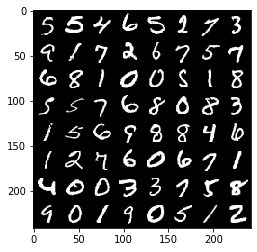

In [3]:
# functions to show an image
def imshow(img):
    #img = img / 0.3081 + 0.1307    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).mean(2), cmap="gray")
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [49]:
def log_train(epoch, batch_idx, loss):
    if log_interval and batch_idx % log_interval == 0:
        p_done = 100. * batch_idx / len(train_loader)
        ntotal = len(train_loader.dataset)
        nprocessed = batch_idx * batch_size
        print(f"Train Epoch: {epoch} [{nprocessed: >5}/{ntotal} ({p_done: >2.0f}%)]\tLoss: {loss:.6f}")

In [58]:
def get_lnorm(model, l_norm=2, alpha=0.001):
    return sum(alpha*torch.norm(param, l_norm) ** l_norm for param in model.parameters())

def train(model, optimizer, epoch, reg=None, regularization=None):
    model.train()
    losses = []
    r = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if reg:
            r = get_lnorm(model, reg)
        loss = F.nll_loss(output, target) + r
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        log_train(epoch, batch_idx, loss)
    return np.mean(losses)

def test(model, reg=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if reg:
                r = get_lnorm(model, reg)
            test_loss += F.nll_loss(output, target, reduction='sum').item() + r
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)
    error = 1 - acc

    if log_interval:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return test_loss, error

In [61]:
import torch.optim as optim
from time import time

def fit_model(model, Optimizer=optim.Adadelta, epochs=15, regularization=None, lr=1e-3):
    train_loss = []
    test_loss = []
    test_errors = []
    start = time()
    model.to(device)

    optimizer = Optimizer(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        loss = train(model, optimizer, epoch, regularization)
        train_loss.append(loss)
        loss, error = test(model, regularization)
        test_loss.append(loss)
        test_errors.append(error)
    print(f'Done training with after {time() - start:.2f} s')

    return model, train_loss, test_loss, test_errors


Training with <class 'torch.optim.sgd.SGD'>
Train Epoch: 1 [    0/60000 ( 0%)]	Loss: 9.086118
Train Epoch: 1 [  640/60000 ( 1%)]	Loss: 9.090348
Train Epoch: 1 [ 1280/60000 ( 2%)]	Loss: 9.067700
Train Epoch: 1 [ 1920/60000 ( 3%)]	Loss: 9.063740
Train Epoch: 1 [ 2560/60000 ( 4%)]	Loss: 9.046093
Train Epoch: 1 [ 3200/60000 ( 5%)]	Loss: 9.021473
Train Epoch: 1 [ 3840/60000 ( 6%)]	Loss: 9.017469
Train Epoch: 1 [ 4480/60000 ( 7%)]	Loss: 8.998329
Train Epoch: 1 [ 5120/60000 ( 9%)]	Loss: 8.993788
Train Epoch: 1 [ 5760/60000 (10%)]	Loss: 8.970759
Train Epoch: 1 [ 6400/60000 (11%)]	Loss: 8.961231
Train Epoch: 1 [ 7040/60000 (12%)]	Loss: 8.959594
Train Epoch: 1 [ 7680/60000 (13%)]	Loss: 8.949190
Train Epoch: 1 [ 8320/60000 (14%)]	Loss: 8.939523
Train Epoch: 1 [ 8960/60000 (15%)]	Loss: 8.928392
Train Epoch: 1 [ 9600/60000 (16%)]	Loss: 8.901584
Train Epoch: 1 [10240/60000 (17%)]	Loss: 8.885859
Train Epoch: 1 [10880/60000 (18%)]	Loss: 8.889526
Train Epoch: 1 [11520/60000 (19%)]	Loss: 8.866397
Train

Train Epoch: 2 [43520/60000 (72%)]	Loss: 7.111323
Train Epoch: 2 [44160/60000 (74%)]	Loss: 7.032143
Train Epoch: 2 [44800/60000 (75%)]	Loss: 7.083952
Train Epoch: 2 [45440/60000 (76%)]	Loss: 7.081244
Train Epoch: 2 [46080/60000 (77%)]	Loss: 7.083922
Train Epoch: 2 [46720/60000 (78%)]	Loss: 7.033020
Train Epoch: 2 [47360/60000 (79%)]	Loss: 7.050401
Train Epoch: 2 [48000/60000 (80%)]	Loss: 7.038321
Train Epoch: 2 [48640/60000 (81%)]	Loss: 6.993908
Train Epoch: 2 [49280/60000 (82%)]	Loss: 6.950289
Train Epoch: 2 [49920/60000 (83%)]	Loss: 6.934308
Train Epoch: 2 [50560/60000 (84%)]	Loss: 6.932384
Train Epoch: 2 [51200/60000 (85%)]	Loss: 6.951435
Train Epoch: 2 [51840/60000 (86%)]	Loss: 6.842591
Train Epoch: 2 [52480/60000 (87%)]	Loss: 6.898906
Train Epoch: 2 [53120/60000 (88%)]	Loss: 6.818754
Train Epoch: 2 [53760/60000 (90%)]	Loss: 6.815956
Train Epoch: 2 [54400/60000 (91%)]	Loss: 6.810348
Train Epoch: 2 [55040/60000 (92%)]	Loss: 6.816624
Train Epoch: 2 [55680/60000 (93%)]	Loss: 6.857305


Train Epoch: 2 [26240/60000 (44%)]	Loss: 1.603578
Train Epoch: 2 [26880/60000 (45%)]	Loss: 1.748917
Train Epoch: 2 [27520/60000 (46%)]	Loss: 1.655149
Train Epoch: 2 [28160/60000 (47%)]	Loss: 1.640032
Train Epoch: 2 [28800/60000 (48%)]	Loss: 1.679291
Train Epoch: 2 [29440/60000 (49%)]	Loss: 1.544948
Train Epoch: 2 [30080/60000 (50%)]	Loss: 1.610758
Train Epoch: 2 [30720/60000 (51%)]	Loss: 1.495290
Train Epoch: 2 [31360/60000 (52%)]	Loss: 1.571846
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.541212
Train Epoch: 2 [32640/60000 (54%)]	Loss: 1.574542
Train Epoch: 2 [33280/60000 (55%)]	Loss: 1.479079
Train Epoch: 2 [33920/60000 (57%)]	Loss: 1.513944
Train Epoch: 2 [34560/60000 (58%)]	Loss: 1.308174
Train Epoch: 2 [35200/60000 (59%)]	Loss: 1.370235
Train Epoch: 2 [35840/60000 (60%)]	Loss: 1.356837
Train Epoch: 2 [36480/60000 (61%)]	Loss: 1.388967
Train Epoch: 2 [37120/60000 (62%)]	Loss: 1.399377
Train Epoch: 2 [37760/60000 (63%)]	Loss: 1.319356
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.517835


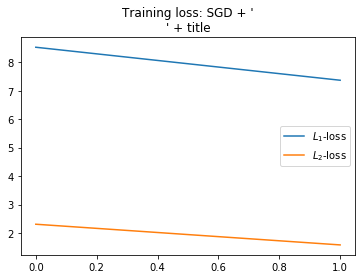

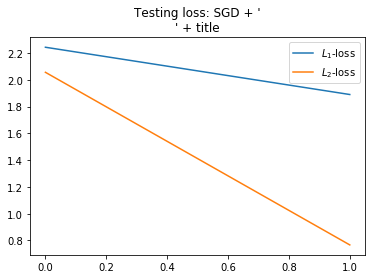

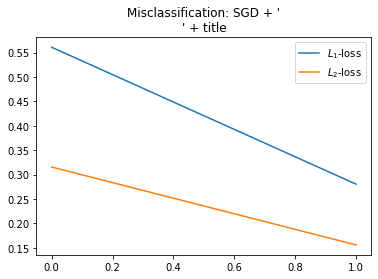


Training with <class 'torch.optim.adadelta.Adadelta'>
Train Epoch: 1 [    0/60000 ( 0%)]	Loss: 9.093022
Train Epoch: 1 [  640/60000 ( 1%)]	Loss: 9.090261
Train Epoch: 1 [ 1280/60000 ( 2%)]	Loss: 9.072048
Train Epoch: 1 [ 1920/60000 ( 3%)]	Loss: 9.074690
Train Epoch: 1 [ 2560/60000 ( 4%)]	Loss: 9.051548
Train Epoch: 1 [ 3200/60000 ( 5%)]	Loss: 9.057211
Train Epoch: 1 [ 3840/60000 ( 6%)]	Loss: 9.046141
Train Epoch: 1 [ 4480/60000 ( 7%)]	Loss: 9.035427
Train Epoch: 1 [ 5120/60000 ( 9%)]	Loss: 9.015150
Train Epoch: 1 [ 5760/60000 (10%)]	Loss: 9.019367
Train Epoch: 1 [ 6400/60000 (11%)]	Loss: 8.993876
Train Epoch: 1 [ 7040/60000 (12%)]	Loss: 8.984680
Train Epoch: 1 [ 7680/60000 (13%)]	Loss: 8.961703
Train Epoch: 1 [ 8320/60000 (14%)]	Loss: 8.967592
Train Epoch: 1 [ 8960/60000 (15%)]	Loss: 8.939340
Train Epoch: 1 [ 9600/60000 (16%)]	Loss: 8.932237
Train Epoch: 1 [10240/60000 (17%)]	Loss: 8.916478
Train Epoch: 1 [10880/60000 (18%)]	Loss: 8.906770
Train Epoch: 1 [11520/60000 (19%)]	Loss: 8.90

Train Epoch: 2 [43520/60000 (72%)]	Loss: 7.197934
Train Epoch: 2 [44160/60000 (74%)]	Loss: 7.194712
Train Epoch: 2 [44800/60000 (75%)]	Loss: 7.177705
Train Epoch: 2 [45440/60000 (76%)]	Loss: 7.182127
Train Epoch: 2 [46080/60000 (77%)]	Loss: 7.122651
Train Epoch: 2 [46720/60000 (78%)]	Loss: 7.146414
Train Epoch: 2 [47360/60000 (79%)]	Loss: 7.140210
Train Epoch: 2 [48000/60000 (80%)]	Loss: 7.141115
Train Epoch: 2 [48640/60000 (81%)]	Loss: 7.104158
Train Epoch: 2 [49280/60000 (82%)]	Loss: 7.107161
Train Epoch: 2 [49920/60000 (83%)]	Loss: 7.069076
Train Epoch: 2 [50560/60000 (84%)]	Loss: 7.097881
Train Epoch: 2 [51200/60000 (85%)]	Loss: 7.038780
Train Epoch: 2 [51840/60000 (86%)]	Loss: 7.054561
Train Epoch: 2 [52480/60000 (87%)]	Loss: 7.068779
Train Epoch: 2 [53120/60000 (88%)]	Loss: 7.003432
Train Epoch: 2 [53760/60000 (90%)]	Loss: 7.022831
Train Epoch: 2 [54400/60000 (91%)]	Loss: 7.018094
Train Epoch: 2 [55040/60000 (92%)]	Loss: 6.993721
Train Epoch: 2 [55680/60000 (93%)]	Loss: 6.973032


KeyboardInterrupt: 

In [68]:
from torch.nn.init import *
import torch.optim as optim

epochs = 2
regularization = {'$L_1$-loss': 1,
                  '$L_2$-loss': 2}

losses_names = {'train_loss': 'Training loss',
                'test_loss': 'Testing loss',
                'test_errors': 'Misclassification'}

optimizers = [optim.SGD, optim.Adadelta, optim.Adam]
results = {}
for optimizer in optimizers:
    print(f"\nTraining with {optimizer}")
    optim_results = {}
    for name, reg in regularization.items():
        t = fit_model(Net(), regularization=reg, epochs=epochs, Optimizer=optimizer)
        model, train_loss, test_loss, test_errors = t
        optim_results[name] = {'model': model, 'train_loss': train_loss, 'test_loss':test_loss, 'test_errors': test_errors}
    results[optimizer] = optim_results

    for loss_name, title in losses_names.items():
        for name, result in optim_results.items():
            plt.plot(result[loss_name], label=name)
        optimizer_name = str(optimizer).split(".")[-1][:-2]
        plt.title(f"{title}: {optimizer_name}")
        plt.legend()
        plt.savefig(f"{optimizer_name}-{loss_name}-L{reg}-loss.pdf")
        plt.show()